# FEATURES ANALYSIS

In [1]:
import contextlib
import gc
import joblib
import pickle
import numpy as np
import pandas as pd

from report.tsne import tsne_scatter
from report.umap import umap_scatter
from models.processors import pca_and_normalization
from torchvision.transforms import functional as F

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

@contextlib.contextmanager
def clear_memory():
    try:
        yield
    finally:
        gc.collect()

In [2]:
DVGG_PATH = "./experiments/dvgg/version_0/artifacts/2"

clu = joblib.load(f'{DVGG_PATH}/clustering.dump')

with open(f'{DVGG_PATH}/features.dump', 'rb') as f:
    features = np.load(f)

with open(f'{DVGG_PATH}/features-targets.dump', 'rb') as f:
    feature_targets = np.load(f)

with open(f"./experiments/dvgg/version_0/dvgg-original-targets.dump", "rb") as f:
    original_train_targets = pickle.load(f)

data = pca_and_normalization(features, apply_normalization=False, apply_l2_normalization=False, pca=2)
data = pd.DataFrame(data)
data['targets'] = original_train_targets

## ORIGINAL GROUPS

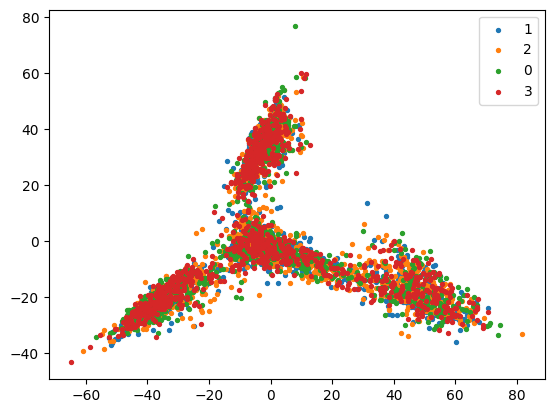

In [22]:
for i in data['targets'].unique():
    plt.scatter(data[data['targets'] == i][0], data[data['targets'] == i][1], marker='o', s=8, label=i)
plt.legend()
plt.show()

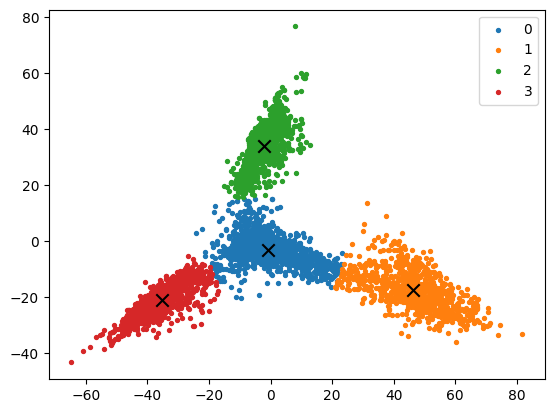

In [23]:
clu = KMeans(init="k-means++", n_clusters=4, n_init=20, random_state=333, verbose=0)
clu.fit(data[[0, 1]])
centroids = clu.cluster_centers_
labels = clu.labels_
u_labels = np.unique(labels)
 
for i in u_labels:
    plt.scatter(data[labels == i][0], data[labels == i][1], marker='o', s=8, label=i)

plt.scatter(centroids[:, 0] , centroids[:, 1] , s=80, marker='x', color='k')

plt.legend()
plt.show()

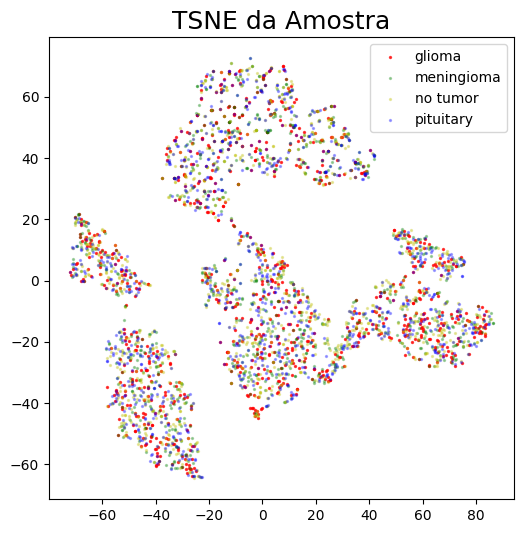

In [28]:
tsne_scatter(features, labels=original_train_targets, dimensions=2)

/Users/arthuralvim/Library/Caches/pypoetry/virtualenvs/xai-clustering-b3gHD5dt-py3.9/lib/python3.9/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.9 is maybe too old for this OS.
  warnings.warn(


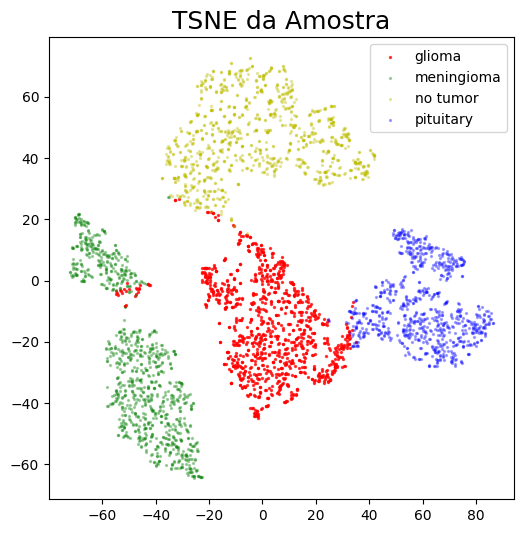

In [10]:
tsne_scatter(features, labels=feature_targets, dimensions=2)

In [ ]:
with clear_memory():
    umap_scatter(features, labels=clu.labels_, dimensions=2)

# LAYER WISE PROPAGATION RELEVANCE

In [2]:
import os
import torch
import copy

from models.vgg import VGG
from models.vgg_deep import DVGG
from data.brain_tumor_mri import BrainTumorMRI
from interpret.layer_wise_rp import LayerWiseRP
from report.lwrp import plot_relevance, analyze_example

In [3]:
CUDA_AVAILABLE = torch.cuda.is_available()
DEVICE = torch.device("cpu:0")
DATASETS_PATH = './datasets/'

brain_tumor = BrainTumorMRI(DATASETS_PATH, train_size=0.7, val_size=0.3, random_state=555)

## MODELS

In [4]:
VGG_PATH = "./experiments/vgg/version_0/checkpoints/vgg-epoch=29-train_loss=0.3726-train_acc=0.8694-val_loss=0.3531-val_acc=0.8716.ckpt"
vgg = VGG.load_from_checkpoint(VGG_PATH)

In [5]:
DVGG_PATH = "./experiments/dvgg/version_0/checkpoints/dvgg-epoch=2-train_loss=0.1296-train_acc=0.9587-val_loss=0.0915-val_acc=0.9667.ckpt"
dvgg = DVGG.load_from_checkpoint(DVGG_PATH)

## ANALYZING IMAGES

In [6]:
dataset = brain_tumor.test_dataset
dataloader = brain_tumor.test_dataloader

In [7]:
dataset.class_to_idx

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [8]:
samples = pd.DataFrame(dataset.imgs, columns=["img", "target"]).groupby("target").sample(3).reset_index()
samples.head()

,index,img,target
0,156,datasets/brain-tumor-mri-dataset/Testing/gliom...,0
1,46,datasets/brain-tumor-mri-dataset/Testing/gliom...,0
2,208,datasets/brain-tumor-mri-dataset/Testing/gliom...,0
3,345,datasets/brain-tumor-mri-dataset/Testing/menin...,1
4,578,datasets/brain-tumor-mri-dataset/Testing/menin...,1


In [9]:
data = []
targets = []
for d, t in dataloader:
    data.append(d)
    targets.append(t)
data = np.concatenate(data)
targets = np.concatenate(targets)

In [10]:
def analyze_image(model, image_id, data, labels):
    lw = LayerWiseRP()
    original_image = torch.from_numpy(data[image_id])
    original_label = labels[image_id]
    
    image_lwrp = lw.apply(model, original_image, DEVICE)
    original_image = original_image.unsqueeze(0)
    prediction = model(original_image).max(1).indices.detach().cpu().numpy()
    original_image = original_image.squeeze(0)
    
    analyze_example(
        image=F.to_pil_image(original_image),
        label=original_label.item(),
        image_lwrp=image_lwrp[:, :, 0],
        pred_label=prediction[0]
    )

Ground Truth for this image:  0
Prediction was:  0


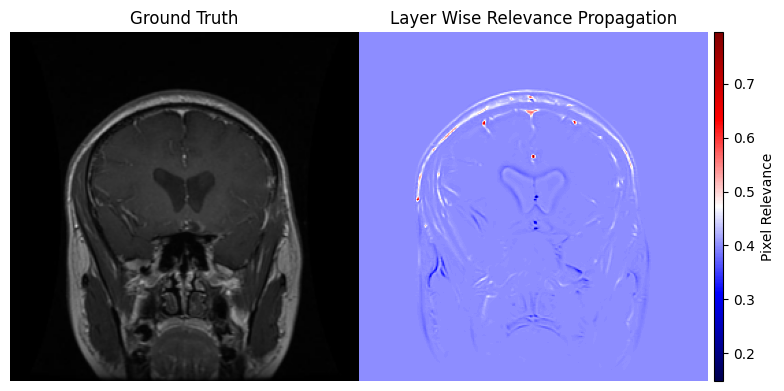

Ground Truth for this image:  0
Prediction was:  0


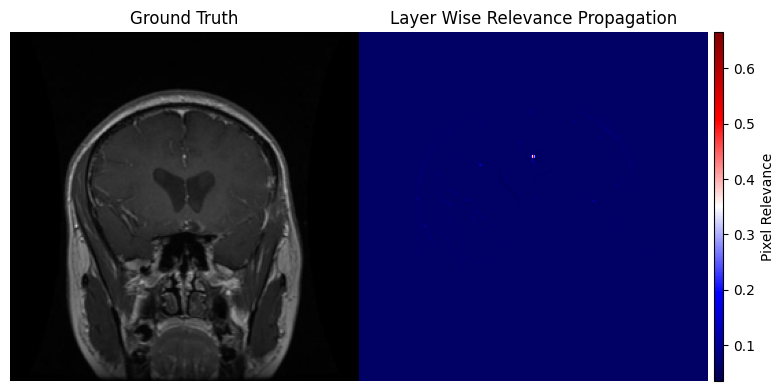

In [13]:
for row in samples.iterrows():
    index = row[1]["index"]
    analyze_image(model=vgg, image_id=index, data=data, labels=targets)
    analyze_image(model=dvgg, image_id=index, data=data, labels=targets)
    break

In [24]:
import shap
from PIL import Image
from torch.utils.data import DataLoader

# Load 200 images from training for background
shap_loader = DataLoader(brain_tumor.train_dataset, batch_size=200, shuffle=True)
background, _ = next(iter(shap_loader))
background = background.to(DEVICE)

In [124]:
# Create SHAP explainer 
vgg_explainer = shap.DeepExplainer(vgg, background)

In [ ]:
# Load test images
# test_images = [Image.open(path) for path in ex_paths]

transformations = brain_tumor.train_dataset.transform

test_samples = samples["img"].apply(Image.open).apply(lambda x: x.convert('RGB')).tolist()[:2]
test_samples = np.array(test_samples)

test_input = [transformations(img) for img in test_samples]
test_input = torch.stack(test_input).to(DEVICE)

In [141]:
from models.timer import Timer

In [ ]:
with Timer(name="shap") as t:
    shap_values = explainer.shap_values(test_input)

In [ ]:
# Reshape shap values and images for plotting
shap_numpy = list(np.array(shap_values).transpose(0, 1, 3, 4, 2))
shap.image_plot(shap_values=shap_numpy, pixel_values=test_numpy, labels=['glioma', 'meningioma', 'notumor', 'pituitary'])

In [86]:



test_images = [Image.open(path) for path in ex_paths]
test_images = np.array(test_images)

# shap.image_plot(shap_numpy, np.array([torch.from_numpy(data[156])]), show=False)
shap.image_plot(shap_values=shap_numpy, pixel_values=np.array([  ]), labels=['glioma', 'meningioma', 'notumor', 'pituitary'])
# shap.image_plot(shap_numpy, data[156], show=True)

The input object of type 'JpegImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'JpegImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
The input object of type 'JpegImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old 

TypeError: int() argument must be a string, a bytes-like object or a number, not 'JpegImageFile'

In [ ]:
test_samples = samples["img"].apply(Image.open).tolist()

In [120]:
pil1 = Image.open(samples["img"][1])
# pil2 = Image.open(samples["img"][2])
print(pil1)
# print(pil2)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x14F42BCA0>


In [117]:
np.array(pil2).shape

(512, 512)

In [121]:
test_samples = [pil1, ]
test_numpy = np.array([np.array(img) for img in test_samples])

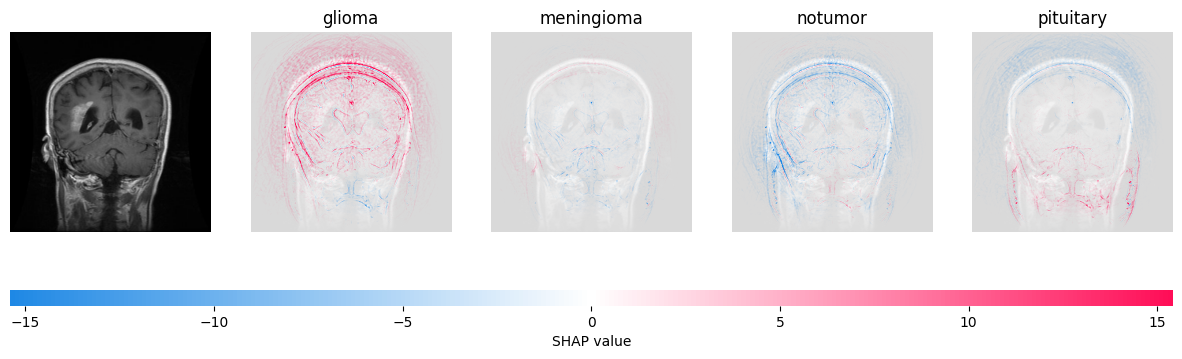

In [122]:
# Reshape shap values and images for plotting
shap_numpy = list(np.array(shap_values).transpose(0, 1, 3, 4, 2))
shap.image_plot(shap_values=shap_numpy, pixel_values=test_numpy, labels=['glioma', 'meningioma', 'notumor', 'pituitary'])